# Adding coordinates to Events

In [1]:
coordinates_file_path = "location_coordinates.csv"
events_file_path = "./../event_data/Sündmused_2011-2015_Marek.xlsx"
cached_events_file_path = "./../Cache/events.csv"
events_with_coordinates_file_path = "events_with_coordinates.csv"


import os, sys
lib_path = os.path.abspath(os.path.join('..', 'py'))
sys.path.append(lib_path)

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import google_geocoding as geo
import rescue_events as re

### 1) Loading data

In [2]:
events = re.load(events_file_path, cached_events_file_path)

Loading Data
Data Loaded!
110478 events loaded
9814 rows have missing datetime - removing



### 2) Constructing query strings for Geocoding API

In [3]:
query_column = "LocQuery"
def add_geo_query(df):
    # Add city name to Tallinn
    
    selector = df.Maakond=="Tallinn"
    
    df[query_column] = df["Linn,vald"].astype("str")
    
    query_string = df["Linn,vald"]
    query_string = query_string[selector].str.cat(df.Maakond[selector], sep=', ')
    df.ix[selector, query_column] = query_string
    
    df[query_column] = df[query_column].astype(str) + ", Estonia"
    return df

place_cols = ["Maakond", "Linn,vald"]
places = events[place_cols].drop_duplicates(place_cols)
places = add_geo_query(places)
places.head()

,Maakond,"Linn,vald",LocQuery
1.501010e+09,Saare mk,Mustjala vald,"Mustjala vald, Estonia"
1.501010e+09,Valga mk,Puka vald,"Puka vald, Estonia"
1.501010e+09,Harju mk,Maardu,"Maardu, Estonia"
1.501010e+09,Saare mk,Salme vald,"Salme vald, Estonia"
1.501010e+09,Tallinn,Lasnamäe,"Lasnamäe, Tallinn, Estonia"


### 3)Loading previously saved coordinates

In [4]:
df_loc = pd.DataFrame(index=places.LocQuery.unique(), columns=['lng','lat'])
try:
    loaded = pd.read_csv(coordinates_file_path, index_col=0)
except OSError:
    pass
else:
    merged = df_loc.merge(loaded, how='left', left_index=True, right_index=True, suffixes=('', '_loaded'))
    df_loc.lng = merged.lng_loaded
    df_loc.lat = merged.lat_loaded

### 3) Lookup missing coordinates from Geolocation API

In [5]:
missing_data = df_loc[df_loc.isnull().any(axis=1)]
missing_data 
for loc_name in missing_data.index:
    try:
        location = geo.get_location(loc_name)
    except LookupError as e:
        print(e)
        continue;
    print(loc_name, end="\t")
    print(location)
    df_loc.set_value(loc_name, "lng", location["lng"])
    df_loc.set_value(loc_name, "lat", location["lat"])
df_loc.head()

Could not find coordinates for nan, Estonia


,lng,lat
"Mustjala vald, Estonia",22.232800,58.462800
"Puka vald, Estonia",26.227205,58.052534
"Maardu, Estonia",24.980187,59.468770
"Salme vald, Estonia",22.250636,58.164069
"Lasnamäe, Tallinn, Estonia",24.861200,59.433000


In [6]:
df_loc[df_loc.isnull().any(axis=1)]

,lng,lat
"nan, Estonia",NaN,NaN


In [7]:
# Saving the coordinates to file, so we would not need to query the API again next time.
df_loc.to_csv(coordinates_file_path, encoding='utf-8')

### 4)Adding coordinates to events & saving the result

In [8]:
events_with_places = events.merge(places, how='left', on=place_cols)
events_with_coordinates = events_with_places.merge(df_loc, how='left', left_on=query_column, right_index=True)
events_with_coordinates.head()

,"Linn,vald",Maakond,Väljakutse liik SOS,Aeg,LocQuery,lng,lat
0,Mustjala vald,Saare mk,TULEKAHJU VÄLJASPOOL HOONEID,2015-01-01 00:02:01,"Mustjala vald, Estonia",22.232800,58.462800
1,Puka vald,Valga mk,TULEKAHJU VÄLJASPOOL HOONEID,2015-01-01 00:09:33,"Puka vald, Estonia",26.227205,58.052534
2,Maardu,Harju mk,TULEKAHJU HOONES,2015-01-01 00:11:16,"Maardu, Estonia",24.980187,59.468770
3,Salme vald,Saare mk,TULEKAHJU HOONES,2015-01-01 00:19:59,"Salme vald, Estonia",22.250636,58.164069
4,Lasnamäe,Tallinn,TULEKAHJU HOONES,2015-01-01 00:21:00,"Lasnamäe, Tallinn, Estonia",24.861200,59.433000


## Visualizing the results

In [10]:
counts = events_with_coordinates.groupby("LocQuery")[["LocQuery"]].count()
df_counts = counts.merge(df_loc, how='left', left_index=True, right_index=True)
df_counts.head()

,LocQuery,lng,lat
LocQuery,,,
"10 km, Kääpa küla, Lasva vald, Estonia",1,27.112818,57.867981
"103 km, Loomse küla, Halinga vald, Estonia",1,24.504700,58.596900
"126 km, Mällikvere küla, Põltsamaa vald, Estonia",1,25.952200,58.679200
"15 km, Hüüru küla, Saue vald, Estonia",1,24.530675,59.378825
"185 km, Treimani küla, Häädemeeste vald, Estonia",1,24.386751,57.915897


In [11]:
def plot_coords(df, x_col, y_col, label_col=None, marker='o'):
    plt.figure(figsize=(11,8))
    plt.scatter(
        df[x_col], df[y_col], marker = marker,
        cmap = plt.get_cmap('Spectral'))
    
    if (label_col != False):
        for label, x, y in zip((df.index if label_col is None else df[label_col]), df[x_col], df[y_col]):
            plt.annotate(
                label, 
                xy = (x, y), xytext = (-20, 20),
                textcoords = 'offset points', ha = 'right', va = 'bottom',
                bbox = dict(boxstyle = 'round,pad=0.1', fc = 'yellow', alpha = 0.5),
                arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

    plt.show()

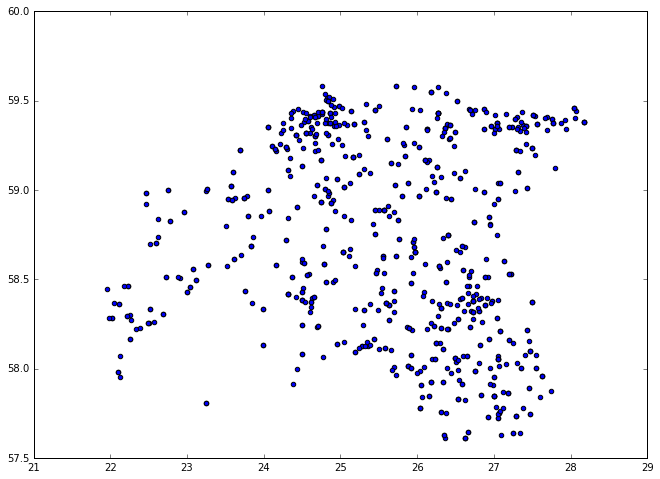

In [12]:
#Places where events are located
plot_coords(df_counts, "lng", "lat", False, marker='o')

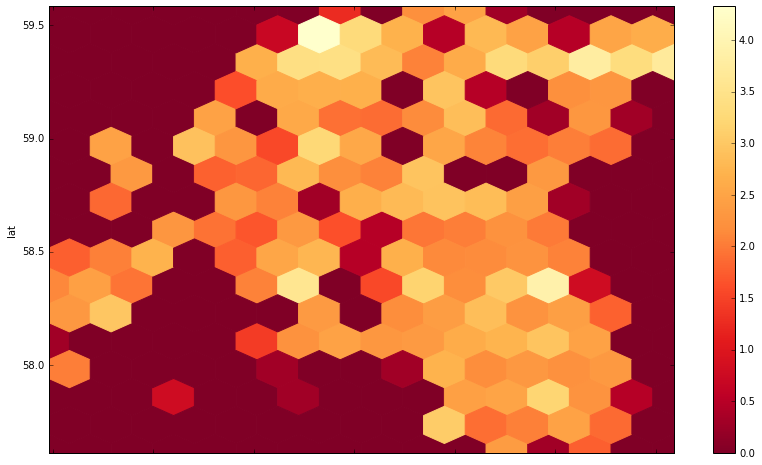

In [13]:
#Distribution of events around estonia
events_with_coordinates.plot(kind='hexbin', x='lng', y='lat', gridsize=15, bins='log',  figsize=(14, 8), cmap=plt.cm.YlOrRd_r);

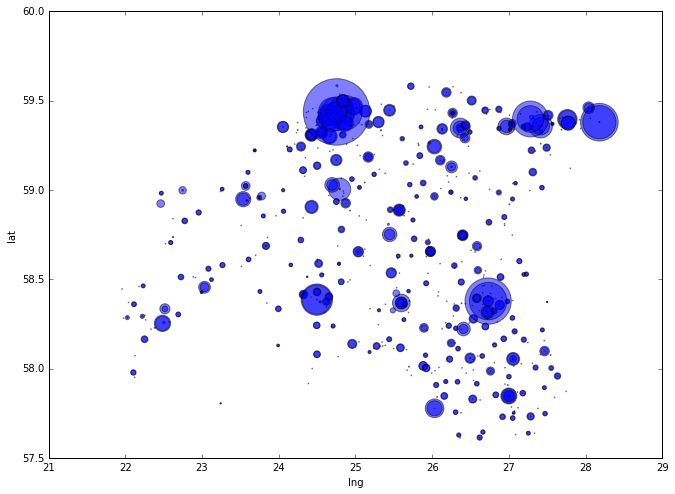

In [14]:
df_counts.plot(kind='scatter', x='lng', y='lat', s=df_counts['LocQuery']*0.5, alpha=0.5, figsize=(11, 8));

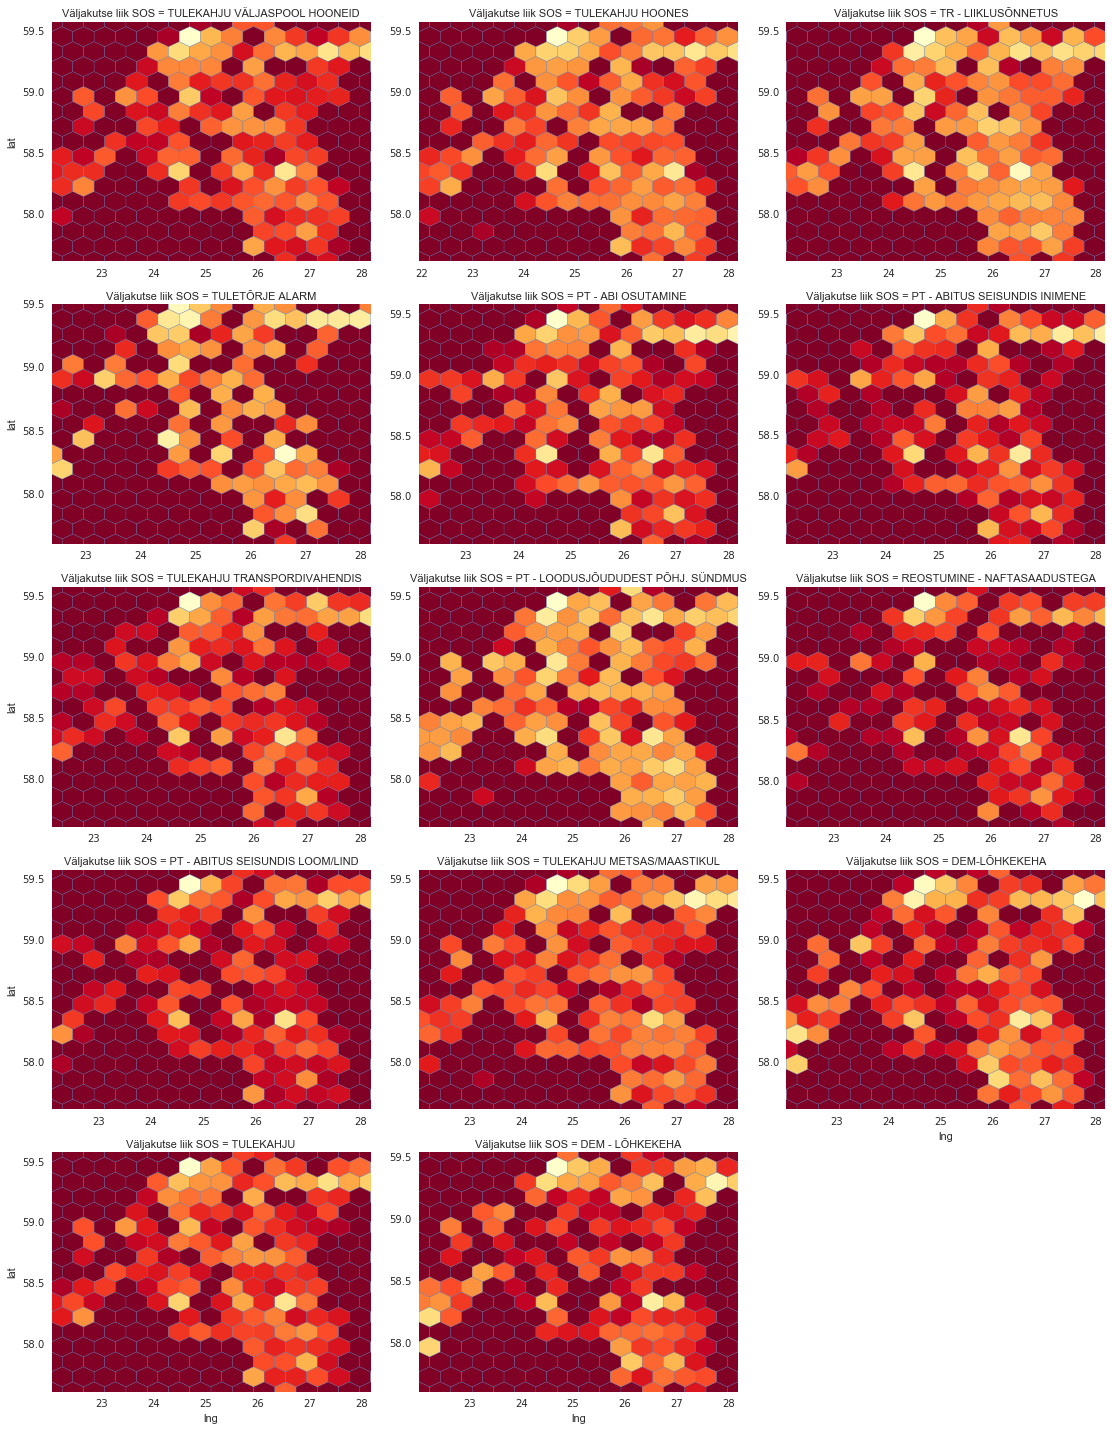

In [15]:
import seaborn as sns
frequent = events_with_coordinates.groupby("Väljakutse liik SOS").count()["LocQuery"]>1200
frequent = frequent[frequent == True]
filtered = events_with_coordinates[events_with_coordinates["Väljakutse liik SOS"].isin(frequent.index)]

g = sns.FacetGrid(filtered, col="Väljakutse liik SOS", sharex=False, sharey=False, size=4,aspect=1.3, col_wrap=3) #figsize=(15, 8)
g.map(plt.hexbin,'lng', 'lat', gridsize=15, bins='log', cmap=plt.cm.YlOrRd_r);